In [1]:
from typing import Optional, Tuple
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]
})
import seaborn as sns
sns.set()
cp = sns.color_palette()
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import FrEIA.framework as ff
import FrEIA.modules as fm
from tqdm.notebook import tqdm
from IPython import display

In [2]:
def plot_data(ax: plt.Axes, x: Optional[np.ndarray] = None, y: Optional[np.ndarray] = None, recon: Optional[np.ndarray] = None) -> None:
    if x is not None and y is not None:
        ax.scatter(x[:,0][y == 0], x[:,1][y == 0], color=cp[0])
        ax.scatter(x[:,0][y == 1], x[:,1][y == 1], color=cp[1])
    elif x is not None and y is None:
        ax.scatter(x[:,0], x[:,1], c=cp[0])
    if recon is not None:
        ax.scatter(recon[:,0], recon[:,1], color=cp[2])
    ax.set_aspect("equal")
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])

In [3]:
x, y = make_moons()

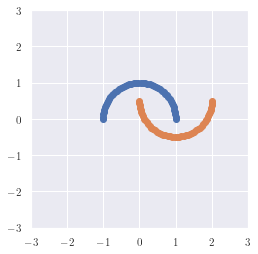

In [4]:
fig, ax = plt.subplots()
plot_data(ax, x, y)
plt.show()

In [5]:
n_blocks = 4
n_epochs = 5000
lr = 1e-4
noise_std = 0.02
rev_loss = True
register_forward_hook = True
plot_every = 50

def subnet_fc(dims_in: int, dims_out: int) -> nn.Sequential:
    return nn.Sequential(
        nn.Linear(dims_in, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, dims_out)
    )

In [6]:
nodes = [ff.InputNode(2, name="inp")]
for i in range(1, n_blocks + 1):
    nodes.append(ff.Node([nodes[-1].out0], fm.PermuteRandom, {"seed": i}, name=f"permute_{i}"))
    nodes.append(ff.Node([nodes[-1].out0], fm.GLOWCouplingBlock, {"clamp": 2.0, "subnet_constructor": subnet_fc}, name=f"coupling_{i}"))
nodes.append(ff.OutputNode([nodes[-1].out0], name="out"))

In [7]:
model = ff.ReversibleGraphNet(nodes, verbose=False).cuda()
x, y = torch.cuda.FloatTensor(x), torch.cuda.FloatTensor(y)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [8]:
def rev_pass(shape: Tuple[int], std: float = 1, device: str = "cuda") -> torch.Tensor:
    z = torch.randn(shape, device=device) * std
    with torch.no_grad():
        recon, _ = model(z, rev=True)
    return recon

def get_intermediate_output(module: nn.Module, inputs: torch.Tensor, outputs: torch.Tensor) -> None:
    out, jac = outputs
    out = out[0]
    feature_maps.append(out.data)

if register_forward_hook:
    for node in model.node_list:
        if isinstance(node.module, fm.coupling_layers._BaseCouplingBlock):
            node.module.register_forward_hook(get_intermediate_output)

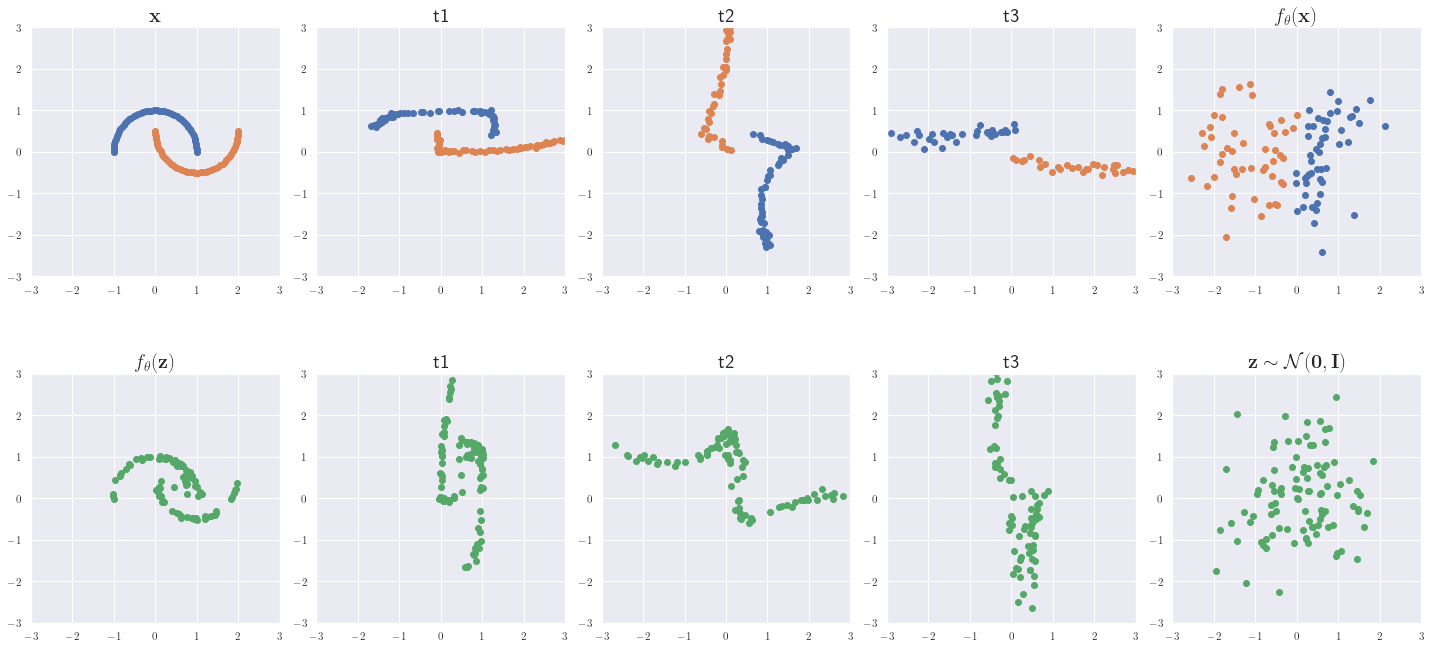

In [9]:
forward_plot_titles = [r"$\mathbf{x}$", *[f"t{i}" for i in range(1, 4)], r"$f_{\theta}(\mathbf{x})$"]
backward_plot_titles = [r"$f_{\theta}(\mathbf{z})$", *[f"t{i}" for i in range(1, 4)], r"$\mathbf{z} \sim \mathcal{N}(\mathbf{0},\mathbf{I})$"]

z = torch.randn(x.shape, device="cuda")

for e in tqdm(range(n_epochs)):
    feature_maps = []
    
    optimizer.zero_grad()
    x_noisy = x + torch.randn(x.shape, device=x.device) * noise_std
    out, jac = model(x_noisy)
    zz = 0.5 * torch.sum(out**2, dim=1)
    nll = zz - jac
    loss = torch.mean(nll)
    loss.backward(retain_graph=rev_loss)
    
    if rev_loss:
        z_noisy = torch.randn((100, 2), device="cuda")
        # z_noisy = z + torch.randn(x.shape, device=x.device) * noise_std
        recon, _ = model(z_noisy, rev=True)
        mse = F.mse_loss(recon, x)
        mse.backward()
    
    nn.utils.clip_grad_norm_(model.parameters(), 2)
    
    optimizer.step()
    out = out.cpu().detach()
    
    if e % plot_every == 0:
        display.clear_output(wait=False)
        fig, (axs_forward, axs_backward) = plt.subplots(2, n_blocks + 1, figsize=(20, 10))
        for ax, fm, title in zip(axs_forward, [x, *feature_maps[:n_blocks]], forward_plot_titles):
            fm = fm.cpu().detach()
            plot_data(ax, fm, y)
            ax.set_title(title, fontsize=20)
        for ax, fm, title in zip(axs_backward, [*feature_maps[n_blocks:][::-1], z], backward_plot_titles):
            fm = fm.cpu().detach()
            plot_data(ax, recon=fm)
            ax.set_title(title, fontsize=20)
        plt.tight_layout()
        # plt.savefig(f"./imgs_moons_example/epoch{e}.png", bbox_inches="tight", dpi=200)
        plt.show()